In [18]:
%load_ext autoreload
%autoreload 2


from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.vision.models.xresnet import *
from fastai.vision.models.unet import DynamicUnet
from bpho import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
torch.cuda.set_device(1)

In [20]:
datasetname = 'tilenorm_002'
data_path = Path('.')
datasets = data_path/'datasets'
datasources = data_path/'data'
dataset = datasets/datasetname

test_files = dataset/'test'
hr_tifs = dataset/'hr_t_512'
lr_up_tifs = dataset/'lrup_t_512'

stats_inputs = Path('stats/input')
mname = 'combo_512'
model_dir = 'models'

loss = F.mse_loss
metrics = sr_metrics

In [28]:
def get_src(x_data, y_data_):
    def map_to_hr(x):
        hr_name = x.relative_to(x_data)
        return y_data_/hr_name
    src = (ImageImageList
            .from_folder(x_data, convert_mode='L')
            .split_by_rand_pct()
            .label_from_func(map_to_hr, convert_mode='L'))
    return src


def get_data(bs, size, x_data, y_data, max_zoom=1.1, **kwargs):
    src = get_src(x_data, y_data)
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size)
            .databunch(bs=bs,**kwargs).normalize())
    data.c = 3
    return data

def do_fit(learn, save_name, lrs=slice(1e-3), pct_start=0.9, cycle_len=10):
    learn.to_fp16().fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    print(f'saved: {save_name}')
    num_rows = min(learn.data.batch_size, 3)
    learn.to_fp32().show_results(rows=num_rows, imgsize=5)

In [29]:
step = 0
lr = 1e-3
cycles = 2
loss = F.l1_loss
metrics = sr_metrics


bs = 8
size = 256
max_zoom = 2
arch = xresnet34

data = get_data(bs, size, lr_up_tifs, hr_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir)
gc.collect()

0

In [30]:
if False:
    learn.lr_find()
    learn.recorder.plot()

In [31]:
#data.train_ds.y.items[0]

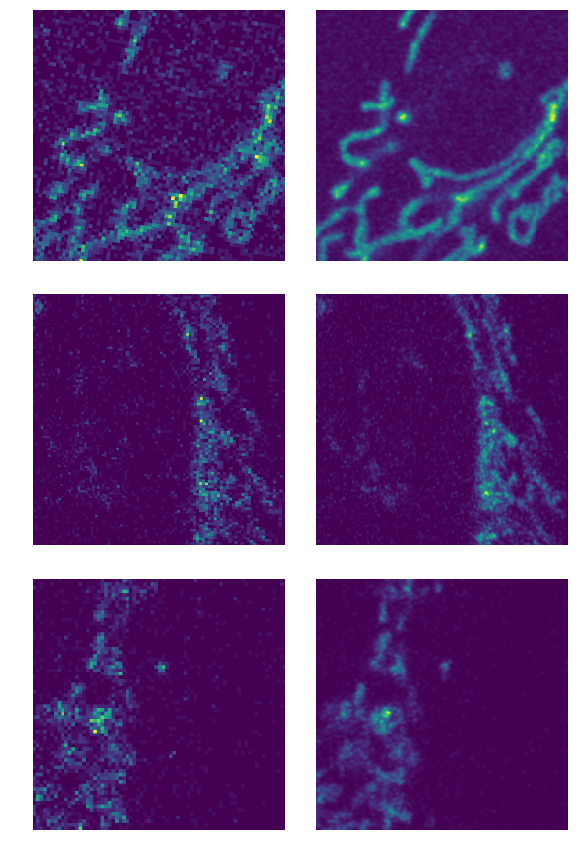

In [32]:
data.show_batch(3)

epoch,train_loss,valid_loss,ssim,psnr,time
0,0.020419,0.015970,0.776169,31.075502,00:09
1,0.018980,0.014366,0.814559,31.178949,00:09


saved: combo_512.00


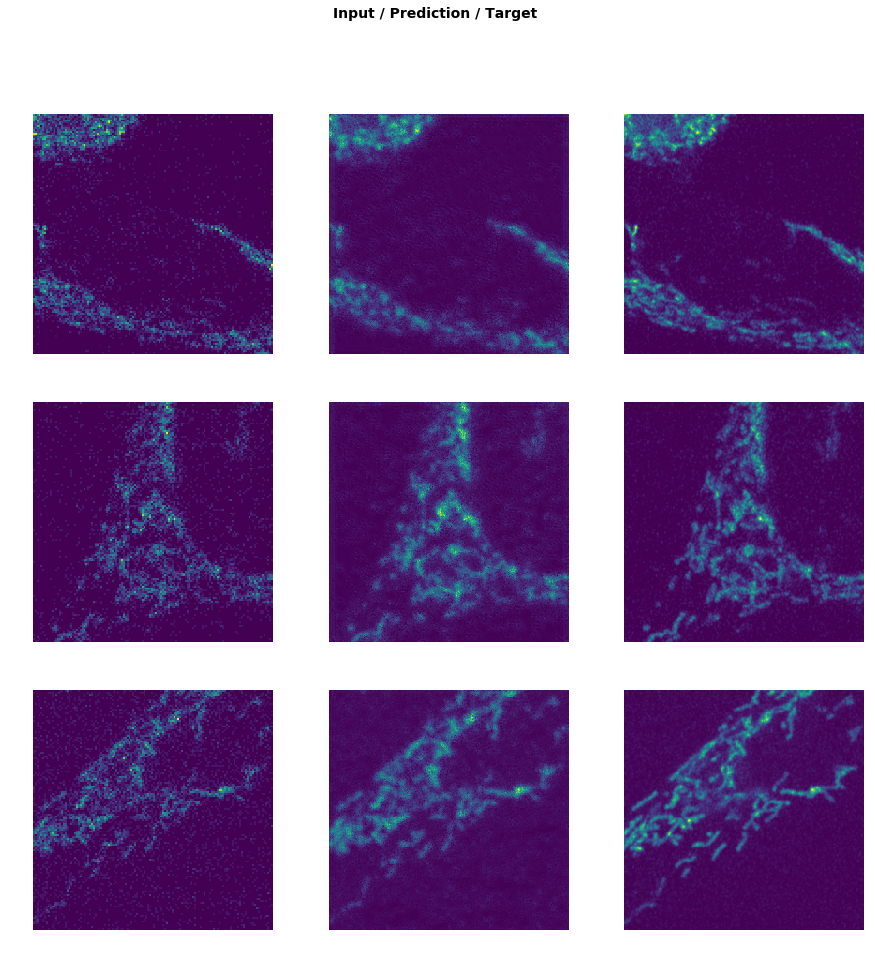

In [34]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

In [27]:
step = 1
lr = 1e-4
cycles = 2
loss = F.l1_loss
metrics = sr_metrics


bs = 12
size = 512
max_zoom = 1.2
arch = xresnet34

data = get_data(bs, size, lr_up_tifs, hr_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir)
learn.load(f'{mname}.{(step-1):02d}')
gc.collect()

0

In [ ]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

In [ ]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr/50, cycle_len=cycles*5)

In [ ]:
hr_tifs = dataset/'hr_t_1024'
lr_up_tifs = dataset/'lrup_t_1024'


step = 2
lr = 1e-4
cycles = 2
loss = F.mse_loss
metrics = sr_metrics


bs = 2
size = 1024
max_zoom = 1.2
arch = xresnet34

data = get_data(bs, size, lr_up_tifs, hr_tifs, max_zoom=max_zoom, num_workers=4)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir)
learn.load(f'{mname}.{(step-1):02d}')
gc.collect()

In [ ]:
do_fit(learn, f'{mname}.{step:02d}', lrs=lr, cycle_len=cycles)

In [ ]:
do_fit(learn, f'{mname}.{step:02d}.1', lrs=lr/50, cycle_len=cycles*5)

In [38]:
p = Path('stats/input/mitotracker/')

test_fns = []

test_fns += list(p.glob('*.tif'))
test_fns += list(p.glob('**/**/*.czi'))

#test_fns = test_fns[0:1]

In [ ]:
len(test_fns)

In [ ]:
#test_fns = []
#test_fns += list(test_files.glob('**/*.tif'))
#test_fns += list(test_files.glob('**/*.czi'))

In [35]:
step = 0
lr = 1e-4
cycles = 2
loss = F.mse_loss
metrics = sr_metrics


bs = 1
size = 512
max_zoom = 2
arch = xresnet34

data = get_data(bs, size, lr_up_tifs, hr_tifs, max_zoom=max_zoom)
learn = xres_unet_learner(data, arch, loss_func=loss, metrics=metrics, model_dir=model_dir)
learn.load(f'{mname}.{step:02d}').to_fp16()
gc.collect()

0

In [36]:
256 / 44

5.818181818181818

In [39]:
dest = Path('/DATA/temp/')
shutil.rmtree(dest)
dest.mkdir(exist_ok=True, parents=True)

generate_tifs(test_fns, dest, learn, size, tag=mname, max_imgs=10)

czi: x:228 y:230 t:10 c:1 z:1 1995


czi: x:228 y:230 t:10 c:1 z:1 1810


In [ ]:
#test = PIL.Image.open('/DATA/temp/actin/C2-low res confocal mito and actin 3_combo_orig.tif')

In [ ]:
9*256

In [ ]:
learn.export('combotile.pkl')

In [ ]:
learn.path

In [ ]:
learn.path = Path('.')

In [ ]:
import czifile
from pathlib import Path
from fastprogress import progress_bar
import pandas as pd
import numpy as np
import PIL.Image
from bpho import *
PIL.Image.MAX_IMAGE_PIXELS = 99999999999999

In [ ]:


p = Path('data/')
fns = list(p.glob('**/mitotracker/**/*.czi'))
print(len(fns))
fn = fns[0]

In [ ]:
info = []
for fn in progress_bar(fns):
     with PIL.Image.open(fn) as tif_f:
        img = np.array(tif_f)
        info.append({'fn': fn, 'category': fn.parts[-3],
                     'ndtype': img.dtype})
df = pd.DataFrame(info)

In [ ]:
df

In [ ]:
f = fns[50]

In [ ]:
!ls data/fixed

In [ ]:
!ls data/fixed/fixed_cell_mitochondria/train

In [ ]:
tif_f = PIL.Image.open(fn)
a = np.array(tif_f)
a.shape

In [ ]:
mi,ma = np.percentile(a, [2,99.8])
print(mi,ma)

In [ ]:
eps = 1e-20 
a = (a - mi) / (ma - mi + eps)

In [ ]:
from fastai import *
from fastai.vision import *
img = Image(tensor(a[None]))

In [ ]:
img

In [ ]:
info = []
for fn in progress_bar(fns):
    if fn.parts[-4] != 'random' and 'great quality' not in fn.stem:
        try:
            with czifile.CziFile(fn) as czi_f:
                data = czi_f.asarray()                
                mi, ma = np.percentile(data, [2, 99.8])
                info.append({'fn': fn, 'ndtype': czi_f.dtype, 'category': fn.parts[-3],
                             'maxval': data.max(), 'mi': mi, 'ma': ma})
        except:
            print('exception', fn)
            pass
df = pd.DataFrame(info)

In [ ]:
df.columns = ['category', 'dtype', 'fn', 'maxval']

In [ ]:
mi, ma = np.percentile(data, [2, 99.8])

In [ ]:
ndata = (data - mi)

In [ ]:
mi

In [ ]:
df

In [ ]:
czi_f = czifile.CziFile(fn)

In [ ]:
data = czi_f.asarray()

In [ ]:
data.dtype, data.shape

In [ ]:
proc_axes, proc_shape = get_czi_shape_info(czi_f)
idx = build_index(proc_axes, {'X': slice(0,18975), 'Y': slice(0,18886)})


In [ ]:
np.percentile(data, 10)

In [ ]:
czi_f.metadata

In [ ]:
%pylab inline

In [ ]:
2**10

In [ ]:
2**12

In [ ]:
2*14

In [ ]:
2**14

In [ ]:
2**13

In [ ]:
df